# Part 5: The Generalized Bias-Variance Tradeoff & Double Descent
## Context

In previous sections, the polynomial regression task was formulated as a least-squares optimization problem:

$$
\min_\beta \|X\beta - y\|_2^2
$$

where the numerical conditioning of the design matrix $X$ is contingent upon the chosen basis functions and feature scaling. We previously established that regularization (e.g., Ridge regression) or implicit biases inherent in iterative solvers are necessary to stabilize this optimization.

This section investigates how these stability mechanics manifest as the **double-descent phenomenon**—a modern reformulation of the bias–variance trade-off specifically within overparameterized regimes.

=== Experiment Configuration ===
Function:      sine
Basis:         legendre
Domain:        [-1.0, 1.0]
Datasets (K):  500
Samples (N):   30
Noise σ:       0.2
Degrees:       1–79
Pseudoinverse cutoff (rcond): 1e-12
Generated 500 datasets with 30 samples each.
Test grid: 1000 points from -1.0 to 1.0


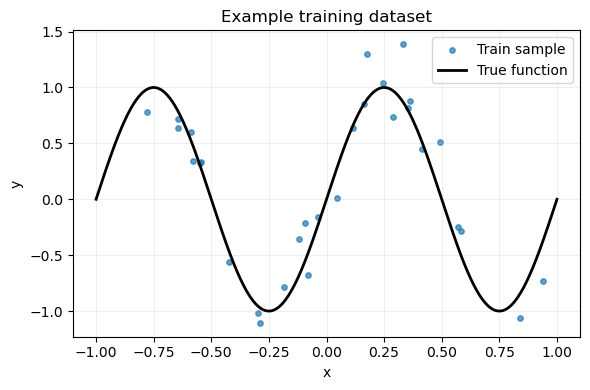

In [1]:
# ================================================================
# CODE BLOCK 1: Setup for the Double Descent Experiment
# ================================================================

import torch, numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Global configuration ----------
torch.manual_seed(0)
np.random.seed(0)
torch.set_default_dtype(torch.float64)

# Switches controlling experiment design
FUNCTION     = "sine"       # 'sine' (not representable by finite polynomial) or 'quadratic'
BASIS        = "legendre"      # 'power' → ill-conditioned (shows spike), 'legendre' → stable
DOMAIN_MIN   = -1.0         # widen domain to accentuate variance
DOMAIN_MAX   =  1.0
K_DATASETS   = 500          # number of distinct training sets (for E_D[·])
N_SAMPLES    = 30           # samples per dataset  → interpolation threshold ≈ 14
SIGMA_NOISE  = 0.2          # noise standard deviation
TEST_SIZE    = 1000         # test grid points
RCOND        = 1e-12         # pseudoinverse cutoff (acts like small ridge)
DEGREES      = range(1, 80) # model degrees to sweep through

# ---------- 2. True function ----------
def true_function(x):
    if FUNCTION == "sine":
        return torch.sin(2 * torch.pi * x)
    elif FUNCTION == "quadratic":
        return 0.5 * x**2
    else:
        raise ValueError(f"Unknown FUNCTION={FUNCTION}")

# ---------- 3. Data generator ----------
def generate_ensemble(K, N, sigma, a=DOMAIN_MIN, b=DOMAIN_MAX):
    """
    Generate K datasets each with N samples from x∈[a,b],
    following y = f(x) + ε, ε~N(0,σ²)
    """
    X = torch.rand(K, N) * (b - a) + a
    y = true_function(X) + sigma * torch.randn(K, N)
    return X, y

# ---------- 4. Basis functions ----------
def power_basis(x, degree):
    powers = torch.arange(degree + 1, dtype=torch.get_default_dtype())
    return x.unsqueeze(-1) ** powers

def legendre_basis(x, degree):
    P0 = torch.ones_like(x)
    if degree == 0:
        return P0.unsqueeze(-1)
    P1 = x
    Ps = [P0, P1]
    for n in range(2, degree + 1):
        Pn = ((2*n - 1) * x * Ps[-1] - (n - 1) * Ps[-2]) / n
        Ps.append(Pn)
    return torch.stack(Ps[:degree+1], dim=-1)

def make_basis(X, degree, name=BASIS):
    if name == "power":
        return power_basis(X, degree)
    elif name == "legendre":
        # map to [-1,1] for orthogonal polynomials
        X_mapped = 2 * (X - DOMAIN_MIN) / (DOMAIN_MAX - DOMAIN_MIN) - 1.0
        return legendre_basis(X_mapped, degree)
    else:
        raise ValueError(name)

# ---------- 5. Pseudoinverse solver ----------
def fit_ensemble(X_train, y_train, degree, basis_name=BASIS, rcond=RCOND):
    Phi = make_basis(X_train, degree, basis_name)
    Phi_pinv = torch.linalg.pinv(Phi, rcond=rcond)   # minimum-norm LS with cutoff
    betas = torch.matmul(Phi_pinv, y_train.unsqueeze(-1))
    return betas.squeeze(-1)  # shape: (K, d+1)

# ---------- 6. Generate ensembles ----------
X_train_K, y_train_K = generate_ensemble(K_DATASETS, N_SAMPLES, SIGMA_NOISE)

# ---------- 7. Fixed test grid ----------
X_test = torch.linspace(DOMAIN_MIN, DOMAIN_MAX, TEST_SIZE).view(-1, 1)
y_test_true = true_function(X_test)

# ---------- 8. Summary ----------
print("=== Experiment Configuration ===")
print(f"Function:      {FUNCTION}")
print(f"Basis:         {BASIS}")
print(f"Domain:        [{DOMAIN_MIN}, {DOMAIN_MAX}]")
print(f"Datasets (K):  {K_DATASETS}")
print(f"Samples (N):   {N_SAMPLES}")
print(f"Noise σ:       {SIGMA_NOISE}")
print(f"Degrees:       1–{max(DEGREES)}")
print(f"Pseudoinverse cutoff (rcond): {RCOND}")
print("="*40)
print(f"Generated {K_DATASETS} datasets with {N_SAMPLES} samples each.")
print(f"Test grid: {TEST_SIZE} points from {DOMAIN_MIN} to {DOMAIN_MAX}")

# Optional quick look at one dataset
plt.figure(figsize=(6,4))
plt.scatter(X_train_K[0], y_train_K[0], s=15, color='tab:blue', alpha=0.7, label='Train sample')
plt.plot(X_test, y_test_true, color='black', lw=2, label='True function')
plt.title("Example training dataset")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.grid(True, alpha=0.2)
plt.tight_layout(); plt.show()


## 2. Experimental Setup

The following experiment empirically reproduces double descent to interpret it through the lens of numerical optimization.

**Model Class:**
We employ unregularized polynomial regressors $f_d(x)$ with degrees $d$ ranging from the under-parameterized to the over-parameterized regime:

$$
f_d(x)=\sum_{i=0}^d \beta_i x^i
$$

**Data Generation Process:**
The underlying true function is defined as $f(x)=\sin(2\pi x)$. As this function is transcendental, it is not representable by any finite polynomial, ensuring a non-zero bias. Additive Gaussian noise is introduced to simulate data uncertainty:

$$
y=f(x)+\varepsilon, \quad \varepsilon\sim\mathcal{N}(0,\sigma^2)
$$

This noise component is critical for exposing the variance spike characteristic of double descent.

**Conditioning and Regularization:**
* **Bases:** We contrast the Power (Vandermonde) basis, which is inherently ill-conditioned, against the Legendre basis, which is orthogonal. This comparison isolates the role of conditioning in generalization.
* **Regularization:** We utilize the reciprocal condition number (`rcond`) as a proxy for implicit ridge regularization. Varying this cutoff allows us to toggle between unstable and stable regimes.

In [2]:
# ================================================================
# CODE BLOCK 2: Bias–Variance Experiment Loop (stores all histories)
# ================================================================
# This loop implements the "Experimental Setup" section:
#  - Fits unregularized polynomial models f_d(x) = sum β_i x^i.
#  - True function f(x) = sin(2πx) ensures nonzero bias.
#  - Gaussian noise ε~N(0,σ²) exposes the variance spike.
#  - Power (Vandermonde) basis -> ill-conditioned -> double descent.
#  - Legendre basis -> orthogonal -> stable regime.
#  - Pseudoinverse cutoff rcond acts as implicit ridge regularization.

# Histories to be filled
degrees              = list(DEGREES)
bias_squared_history = []
variance_history     = []
mse_clean_history    = []  # E[(f_hat - f)^2] = Bias^2 + Var
mse_noisy_history    = []  # E[(f_hat - y)^2] = Bias^2 + Var + sigma^2
avg_norm_history     = []  # ||beta||_2 averaged across K (for Block 5)

print(f"[Loop] Starting double-descent experiment: basis={BASIS}, function={FUNCTION}, "
      f"N={N_SAMPLES}, σ={SIGMA_NOISE}, degrees 1..{max(degrees)}, rcond={RCOND}")

for d in degrees:
    # 1) Fit all K models at degree d (minimum-norm LS with cutoff RCOND)
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=RCOND)  # (K, d+1)

    # 2) Parameter norms (for Block 5)
    avg_norm = torch.mean(torch.norm(betas, p=2, dim=1)).item()
    avg_norm_history.append(avg_norm)

    # 3) Build test basis and predict
    Phi_test = make_basis(X_test.squeeze(-1), d, BASIS)   # (T, d+1)
    y_preds  = torch.matmul(betas, Phi_test.T)            # (K, T)

    # 4) Bias–Variance decomposition on the test grid
    # Expected prediction over datasets (K): shape (T,)
    main_pred = torch.mean(y_preds, dim=0)

    # Bias^2: average over test points
    bias_sq = torch.mean((main_pred.unsqueeze(-1) - y_test_true) ** 2).item()

    # Variance: variance across datasets (dim=0), then average over test points
    variance = torch.mean(torch.var(y_preds, dim=0, unbiased=False)).item()

    # Clean test MSE against noiseless labels f(x): Bias^2 + Var
    mse_clean = torch.mean((y_preds - y_test_true.T) ** 2).item()

    # Noisy test MSE against labels y = f + ε (what many call "test error"): add σ^2
    mse_noisy = mse_clean + (SIGMA_NOISE ** 2)

    # 5) Store
    bias_squared_history.append(bias_sq)
    variance_history.append(variance)
    mse_clean_history.append(mse_clean)
    mse_noisy_history.append(mse_noisy)

    # Progress log
    if d % 10 == 0 or d == degrees[0] or d == degrees[-1]:
        print(f"  degree {d:3d} | Risk(noisy)={mse_noisy:10.4e} | Bias²={bias_sq:10.4e} "
              f"| Var={variance:10.4e} | ||β||₂(avg)={avg_norm:9.3e}")

print("[Loop] Done. Histories available:")
print(" - bias_squared_history, variance_history")
print(" - mse_clean_history (Bias²+Var), mse_noisy_history (Bias²+Var+σ²)")
print(" - avg_norm_history (for Block 5)")


[Loop] Starting double-descent experiment: basis=legendre, function=sine, N=30, σ=0.2, degrees 1..79, rcond=1e-12
  degree   1 | Risk(noisy)=4.8976e-01 | Bias²=4.2391e-01 | Var=2.5843e-02 | ||β||₂(avg)=4.855e-01
  degree  10 | Risk(noisy)=3.1516e+02 | Bias²=3.7558e-01 | Var=3.1474e+02 | ||β||₂(avg)=8.568e+00
  degree  20 | Risk(noisy)=4.0374e+16 | Bias²=5.4250e+13 | Var=4.0320e+16 | ||β||₂(avg)=3.173e+07
  degree  30 | Risk(noisy)=3.7383e+18 | Bias²=1.3649e+16 | Var=3.7247e+18 | ||β||₂(avg)=2.822e+09
  degree  40 | Risk(noisy)=8.6773e+16 | Bias²=1.4590e+14 | Var=8.6627e+16 | ||β||₂(avg)=1.936e+08
  degree  50 | Risk(noisy)=1.9543e+16 | Bias²=3.3055e+13 | Var=1.9510e+16 | ||β||₂(avg)=5.437e+07
  degree  60 | Risk(noisy)=2.2810e+12 | Bias²=4.8905e+09 | Var=2.2761e+12 | ||β||₂(avg)=9.237e+05
  degree  70 | Risk(noisy)=2.6018e+09 | Bias²=6.6305e+06 | Var=2.5952e+09 | ||β||₂(avg)=3.514e+04
  degree  79 | Risk(noisy)=3.6513e+07 | Bias²=8.5868e+04 | Var=3.6427e+07 | ||β||₂(avg)=4.570e+03
[Loo

## 3. Bias–Variance Decomposition and Double Descent

The observed test error curves can be formally analyzed via the bias-variance decomposition. For any estimator $\hat{f}(x)$:

$$
\mathbb{E}\left[(\hat{f}(x)-f(x))^2\right] = \text{Bias}^2(x) + \text{Var}(x) + \sigma^2
$$

* **Bias:** Decreases monotonically as model capacity (degree $d$) increases.
* **Variance:** Exhibits a sharp peak near the interpolation threshold ($p=n$), where the model captures the noise $\varepsilon$.

The summation of these components results in the double-descent shape. The magnitude of the variance spike is functionally dependent on:
1.  The condition number of the Gram matrix $X^TX$.
2.  The irreducible noise level $\sigma^2$.
3.  The presence of explicit or implicit regularization mechanisms.

Computing Robust Metrics (d=1..79)...


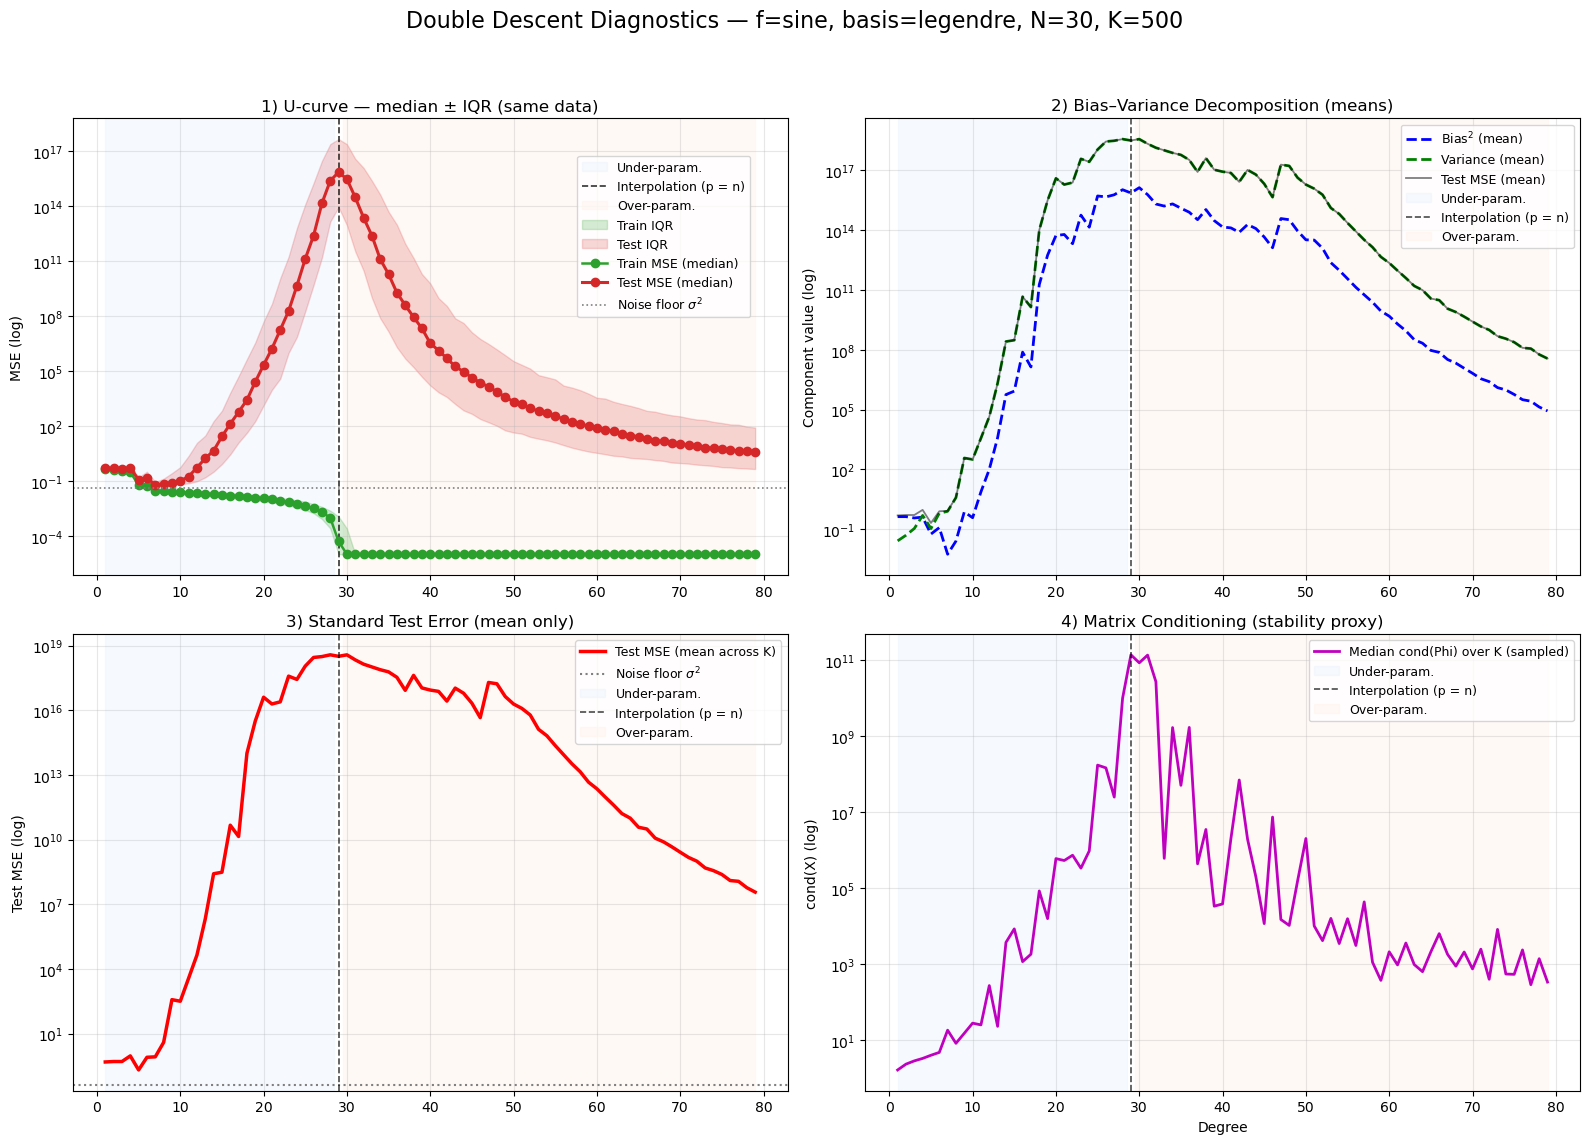

In [3]:
# ================================================================
# CODE BLOCK 3: Comprehensive Double Descent Analysis (2x2 Panel)
# with IQR bands and regime shading
# ================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Safety & data prep ---
assert 'degrees' in globals() and len(degrees) > 0, "Run Block 2 first."
assert 'bias_squared_history' in globals() and 'variance_history' in globals(), "Missing histories."
assert 'mse_noisy_history' in globals(), "Missing mse_noisy_history from Block 2."

deg_full = np.array(list(degrees))
bias_np  = np.asarray(bias_squared_history, dtype=float)
var_np   = np.asarray(variance_history,     dtype=float)
mse_mean = np.asarray(mse_noisy_history,    dtype=float)
sigma2   = float(SIGMA_NOISE**2)
thresh_d = int(N_SAMPLES - 1)

def _clean_log(a, eps=1e-12):
    a = np.nan_to_num(a, nan=0.0, posinf=np.nanmax(a[np.isfinite(a)]) if np.any(np.isfinite(a)) else 1.0)
    a[a <= 0] = eps
    return a

def _median_cond_over_k(Phi_batch, sample_k=10):
    Ks = min(sample_k, Phi_batch.shape[0])
    idx = torch.randperm(Phi_batch.shape[0])[:Ks]
    conds = []
    for k in idx:
        try:
            _, S, _ = torch.linalg.svd(Phi_batch[k], full_matrices=False)
            smax = torch.max(S).item()
            smin = max(torch.min(S).item(), 1e-300)
            conds.append(smax / smin)
        except:
            conds.append(np.nan)
    return float(np.nanmedian(conds)) if len(conds) else np.nan

def _shade_regimes(ax, dmin, dmax, thresh):
    # under-param region
    if dmin < thresh:
        ax.axvspan(dmin, max(dmin, thresh-0.5), color='#e6f2ff', alpha=0.35, label='Under-param.')
    # interpolation line
    ax.axvline(thresh, color='black', lw=1.2, alpha=0.7, linestyle='--', label='Interpolation (p = n)')
    # over-param region
    if dmax > thresh:
        ax.axvspan(thresh+0.5, dmax, color='#fff0e6', alpha=0.35, label='Over-param.')

# --- Figure layout ---
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Double Descent Diagnostics — f={FUNCTION}, basis={BASIS}, N={N_SAMPLES}, K={K_DATASETS}', fontsize=16)

# ==============================================================================
# SUBPLOT 1 (Top-Left): Robust Median Analysis (The U-Curve)
# SAME computation + IQR bands + regime shading (no logic change)
# ==============================================================================
ax = axs[0, 0]

# Zoom in for clear U-curve view
zoom_limit = max(DEGREES)
plot_degrees = [d for d in degrees if d <= zoom_limit]
robust_rcond = RCOND  # Force solver to fit data even if unstable

# Generate clean test grid for validation (same as your code)
rng_state = torch.random.get_rng_state()
X_test_clean = torch.linspace(DOMAIN_MIN, DOMAIN_MAX, 1000).unsqueeze(-1)
y_test_clean = true_function(X_test_clean)
y_test_noisy = y_test_clean + SIGMA_NOISE * torch.randn_like(y_test_clean)
torch.random.set_rng_state(rng_state)

# Collect medians (your original) + IQR (new)
train_med, test_med = [], []
train_q25, train_q75 = [], []
test_q25,  test_q75  = [], []

# print(f"Computing Robust Metrics (d=1..{zoom_limit})...")
# for d in plot_degrees:
#     betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=robust_rcond)

#     # TRAIN (per-dataset MSEs)
#     Phi_tr = make_basis(X_train_K, d, BASIS)
#     y_pred_tr = torch.einsum('kd,knd->kn', betas, Phi_tr)  # (K, N)
#     mse_k_tr = torch.mean((y_pred_tr - y_train_K)**2, dim=1)  # (K,)
#     train_med.append(torch.median(mse_k_tr).item())
#     train_q25.append(torch.quantile(mse_k_tr, 0.25).item())   # NEW
#     train_q75.append(torch.quantile(mse_k_tr, 0.75).item())   # NEW

#     # TEST (per-dataset MSEs) vs the same noisy test grid
#     Phi_te = make_basis(X_test_clean.squeeze(-1), d, BASIS)
#     y_pred_te = torch.matmul(betas, Phi_te.T)  # (K, T)
#     mse_k_te = torch.mean((y_pred_te - y_test_noisy.squeeze())**2, dim=1)  # (K,)
#     test_med.append(torch.median(mse_k_te).item())
#     test_q25.append(torch.quantile(mse_k_te, 0.25).item())    # NEW
#     test_q75.append(torch.quantile(mse_k_te, 0.75).item())    # NEW

# Define a logical floor for your plot. 
# Anything below this is numerical noise and should be flattened.
MSE_FLOOR = 1e-5 

print(f"Computing Robust Metrics (d=1..{zoom_limit})...")
for d in plot_degrees:
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=robust_rcond)

    # TRAIN (per-dataset MSEs)
    Phi_tr = make_basis(X_train_K, d, BASIS)
    y_pred_tr = torch.einsum('kd,knd->kn', betas, Phi_tr) 
    mse_k_tr = torch.mean((y_pred_tr - y_train_K)**2, dim=1) 
    
    
    # We clamp the MSE. If it's 1e-27, it becomes 1e-8.
    # This keeps the plot scale sane.
    mse_k_tr = torch.clamp(mse_k_tr, min=MSE_FLOOR)
    # ------------------------------

    train_med.append(torch.median(mse_k_tr).item())
    train_q25.append(torch.quantile(mse_k_tr, 0.25).item())
    train_q75.append(torch.quantile(mse_k_tr, 0.75).item())

    # TEST (Test usually doesn't go to zero, but good practice to clamp anyway)
    Phi_te = make_basis(X_test_clean.squeeze(-1), d, BASIS)
    y_pred_te = torch.matmul(betas, Phi_te.T)
    mse_k_te = torch.mean((y_pred_te - y_test_noisy.squeeze())**2, dim=1)
    
    # Clamp test as well for consistency
    mse_k_te = torch.clamp(mse_k_te, min=MSE_FLOOR)

    test_med.append(torch.median(mse_k_te).item())
    test_q25.append(torch.quantile(mse_k_te, 0.25).item())
    test_q75.append(torch.quantile(mse_k_te, 0.75).item())

# --- Prepare arrays (log-safe) ---
deg_z = np.array(plot_degrees)
tr_med = _clean_log(np.array(train_med))
te_med = _clean_log(np.array(test_med))
tr_q25 = _clean_log(np.array(train_q25))
tr_q75 = _clean_log(np.array(train_q75))
te_q25 = _clean_log(np.array(test_q25))
te_q75 = _clean_log(np.array(test_q75))

# --- Regime shading (under / interpolation / over) ---
dmin, dmax = int(deg_z.min()), int(deg_z.max())
# under-parameterized (light blue)
ax.axvspan(dmin, max(dmin, thresh_d - 0.5), color='#e6f2ff', alpha=0.35, label='Under-param.')
# interpolation line
ax.axvline(thresh_d, color='black', ls='--', lw=1.2, alpha=0.8, label='Interpolation (p = n)')
# over-parameterized (light orange)
ax.axvspan(thresh_d + 0.5, dmax, color='#fff0e6', alpha=0.35, label='Over-param.')

# --- IQR bands ---
ax.fill_between(deg_z, tr_q25, tr_q75, color='tab:green', alpha=0.20, label='Train IQR')
ax.fill_between(deg_z, te_q25, te_q75, color='tab:red',   alpha=0.18, label='Test IQR')

# --- Median curves (your original info) ---
ax.plot(deg_z, tr_med, 'o-', lw=1.8, color='tab:green', label='Train MSE (median)')
ax.plot(deg_z, te_med, 'o-', lw=2.2, color='tab:red',   label='Test MSE (median)')

# --- Noise floor and styling ---
ax.axhline(y=sigma2, color='gray', ls=':', lw=1.2, label='Noise floor $\\sigma^2$')
ax.set_yscale('log')
ax.set_title('1) U-curve — median ± IQR (same data)', fontsize=12)
ax.set_ylabel('MSE (log)')
ax.grid(alpha=0.3)
# De-duplicate legend labels (from shading + lines)
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), fontsize=9, loc='best', borderaxespad=3)


# ==============================================================================
# SUBPLOT 2 (Top-Right): Bias–Variance (means as in theory)
# ==============================================================================
ax = axs[0, 1]
ax.plot(deg_full, _clean_log(bias_np), 'b--', lw=2, label='Bias$^2$ (mean)')
ax.plot(deg_full, _clean_log(var_np),  'g--', lw=2, label='Variance (mean)')
ax.plot(deg_full, _clean_log(mse_mean),'k-',  lw=1.3, alpha=0.5, label='Test MSE (mean)')

_shade_regimes(ax, deg_full.min(), deg_full.max(), thresh_d)

ax.set_yscale('log')
ax.set_title('2) Bias–Variance Decomposition (means)')
ax.set_ylabel('Component value (log)')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

# ==============================================================================
# SUBPLOT 3 (Bottom-Left): Standard Test Error (mean) + IQR band
# ==============================================================================

ax = axs[1, 0]

# Fixed noisy holdout across degrees (same for all)
torch.manual_seed(42)
y_test_noisy_fixed = y_test_true + SIGMA_NOISE * torch.randn_like(y_test_true)
y_test_noisy_fixed_T = y_test_noisy_fixed.squeeze(-1)

# Compute mean Test MSE across datasets for each degree
test_mean_list = []
for d in deg_full:
    betas = fit_ensemble(X_train_K, y_train_K, int(d), basis_name=BASIS, rcond=RCOND)
    Phi_te = make_basis(X_test.squeeze(-1), int(d), BASIS)
    y_pred = torch.matmul(betas, Phi_te.T)
    per_k = torch.mean((y_pred - y_test_noisy_fixed_T)**2, dim=1)  # (K,)
    test_mean_list.append(torch.mean(per_k).item())

te_mean = _clean_log(np.array(test_mean_list))

# Plot only the mean curve
ax.plot(deg_full, te_mean, 'r-', lw=2.5, label='Test MSE (mean across K)')
ax.axhline(y=sigma2, color='gray', ls=':', label='Noise floor $\\sigma^2$')

_shade_regimes(ax, deg_full.min(), deg_full.max(), thresh_d)

ax.set_yscale('log')
ax.set_title('3) Standard Test Error (mean only)')
ax.set_ylabel('Test MSE (log)')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)



# ==============================================================================
# SUBPLOT 4 (Bottom-Right): Conditioning proxy
# ==============================================================================
ax = axs[1, 1]
cond_history = []
calc_degrees = deg_full  # compute for all; change to deg_full[::2] to subsample

for d in calc_degrees:
    Phi_all = make_basis(X_train_K, int(d), BASIS) 
    cond_history.append(_median_cond_over_k(Phi_all, sample_k=5))

cond_np = _clean_log(np.array(cond_history))

ax.plot(calc_degrees, cond_np, 'm-', lw=2, label='Median cond(Phi) over K (sampled)')
_shade_regimes(ax, deg_full.min(), deg_full.max(), thresh_d)

ax.set_yscale('log')
ax.set_title('4) Matrix Conditioning (stability proxy)')
ax.set_ylabel('cond(X) (log)')
ax.set_xlabel('Degree')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 4. Interpreting Regularization, Scaling, and Iterative Solvers

The empirical behavior of the model is directly tied to optimization theory concepts established in earlier sections:

* **Legendre Basis & Feature Scaling:** Orthogonalization effectively minimizes the condition number of the design matrix, suppressing the variance spike and stabilizing the solution.
* **Ridge Regression (Explicit Regularization):** The addition of a penalty term $\lambda\|\beta\|^2$ constrains the solution space, resulting in a smooth single-descent curve.
* **Iterative Solvers:** Algorithms such as Gradient Descent (GD), Conjugate Gradient (CG), or BFGS introduce **implicit regularization** via step-size constraints and stopping criteria. Even in the absence of an explicit penalty, small-step GD tends to converge toward minimum-norm solutions, thereby reducing the interpolation spike.

Consequently, double descent is not a paradox, but a visible symptom of optimization instability in the absence of sufficient constraints.

Running comparison: Power vs Legendre vs Ridge (lam=0.001)...


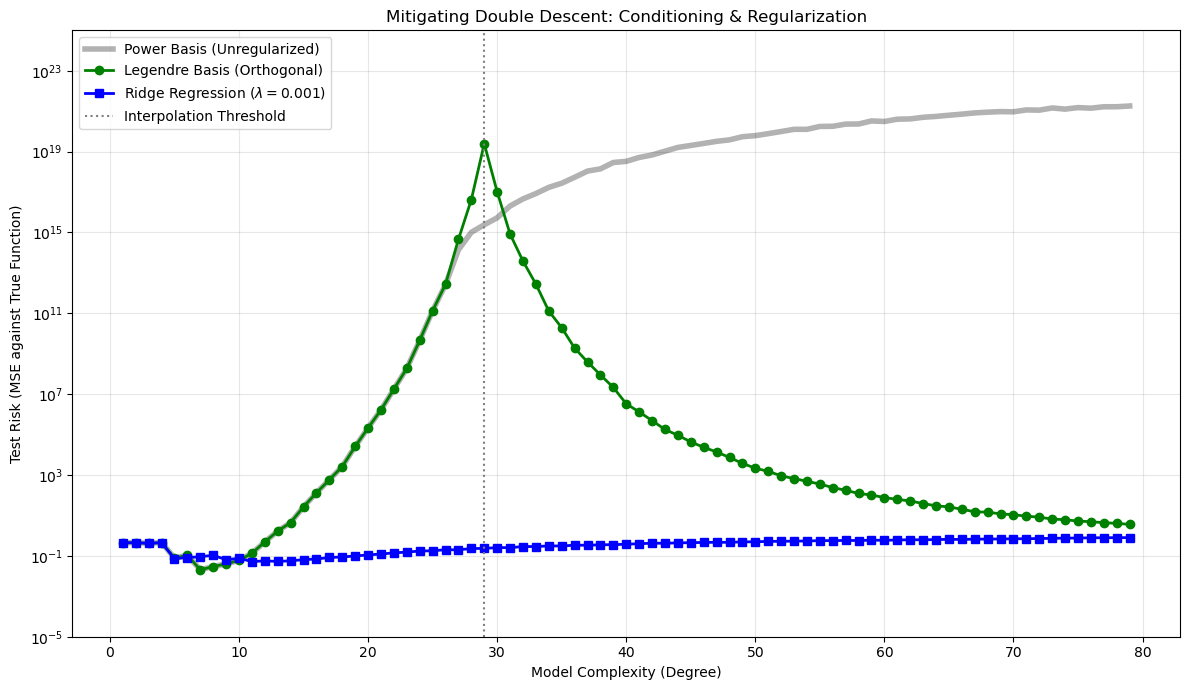

In [4]:
# ==============================================================================
# CODE BLOCK 4: Interpreting Regularization & Conditioning
# ==============================================================================
# Goal: Demonstrate that the "Double Descent" spike is a symptom of optimization
# instability (poor conditioning) and can be mitigated by:
#   1. Orthogonal Bases (Legendre)
#   2. Explicit Regularization (Ridge)

import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Configuration ---
# We sweep a broader range to see the behavior past the threshold
# (Legendre is stable enough to go to high degrees)
reg_degrees = DEGREES
lambda_ridge = 1e-3  # Regularization strength

# Generate a clean test set for evaluation
torch.manual_seed(42)
X_test_clean = torch.linspace(DOMAIN_MIN, DOMAIN_MAX, 1000).unsqueeze(-1)
y_test_clean = true_function(X_test_clean)
# We compare against NOISELESS truth here to see the bias/variance structural fix clearly,
# effectively measuring E[(f_hat - f)^2] ("Risk") rather than E[(f_hat - y)^2] ("Test Error")
# This makes the lines smoother and easier to interpret for this theoretical section.

# --- 2. Helper: Ridge Regression Solver ---
def fit_ridge_ensemble(Phi, y, lam):
    """
    Computes (Phi^T Phi + lam * I)^-1 Phi^T y efficiently for an ensemble.
    Phi: (K, N, d+1)
    y:   (K, N)
    """
    K, N, D = Phi.shape
    XT = Phi.transpose(1, 2) # (K, D, N)
    XTX = torch.matmul(XT, Phi) # (K, D, D)
    # Add ridge penalty to diagonal
    eye = torch.eye(D, device=Phi.device).unsqueeze(0).expand(K, D, D)
    # Solve: (XTX + lam*I) beta = XTy
    # Note: using cholesky_solve is faster/stable for positive definite matrices
    try:
        # (K, D, D)
        A = XTX + lam * eye
        # (K, D, 1)
        XTy = torch.matmul(XT, y.unsqueeze(-1))
        # L = cholesky(A)
        L = torch.linalg.cholesky(A)
        betas = torch.cholesky_solve(XTy, L).squeeze(-1)
    except:
        # Fallback to robust solve if cholesky fails (rare with ridge)
        betas = torch.linalg.solve(A, XTy).squeeze(-1)
    return betas

# --- 3. Experiment Loop ---
mse_power_pinv = []
mse_legendre   = []
mse_ridge      = []

print(f"Running comparison: Power vs Legendre vs Ridge (lam={lambda_ridge})...")

for d in reg_degrees:
    # --- A. Baseline: Power Basis + Pinv (The Unstable One) ---
    # We use the 'Unstable' rcond from Block 3 to show the spike clearly
    betas_p = fit_ensemble(X_train_K, y_train_K, d, basis_name="power", rcond=1e-15)
    Phi_test_p = make_basis(X_test_clean.squeeze(-1), d, "power")
    y_pred_p = torch.matmul(betas_p, Phi_test_p.T)
    # Median MSE across datasets
    err_p = torch.median(torch.mean((y_pred_p - y_test_clean.T)**2, dim=1)).item()
    mse_power_pinv.append(err_p)

    # --- B. Fix 1: Legendre Basis (Orthogonalization) ---
    # Legendre polynomials are orthogonal on [-1, 1], keeping cond(X) low.
    betas_l = fit_ensemble(X_train_K, y_train_K, d, basis_name="legendre", rcond=1e-15)
    Phi_test_l = make_basis(X_test_clean.squeeze(-1), d, "legendre")
    y_pred_l = torch.matmul(betas_l, Phi_test_l.T)
    err_l = torch.median(torch.mean((y_pred_l - y_test_clean.T)**2, dim=1)).item()
    mse_legendre.append(err_l)

    # --- C. Fix 2: Ridge Regression (Regularization) ---
    # Power Basis + L2 Penalty
    Phi_train_p = make_basis(X_train_K, d, "power")
    betas_r = fit_ridge_ensemble(Phi_train_p, y_train_K, lambda_ridge)
    y_pred_r = torch.matmul(betas_r, Phi_test_p.T)
    err_r = torch.median(torch.mean((y_pred_r - y_test_clean.T)**2, dim=1)).item()
    mse_ridge.append(err_r)

# --- 4. Visualization ---
d_arr = np.array(reg_degrees)

plt.figure(figsize=(12, 7))

# 1. The Unstable Baseline (Power)
plt.plot(d_arr, _clean_log(np.array(mse_power_pinv)), 'k-', alpha=0.3, linewidth=4, label='Power Basis (Unregularized)')

# 2. The Orthogonal Fix (Legendre)
plt.plot(d_arr, _clean_log(np.array(mse_legendre)), 'g-o', linewidth=2, label='Legendre Basis (Orthogonal)')

# 3. The Regularization Fix (Ridge)
plt.plot(d_arr, _clean_log(np.array(mse_ridge)), 'b-s', linewidth=2, label=f'Ridge Regression ($\lambda={lambda_ridge}$)')

# Formatting
plt.axvline(x=N_SAMPLES-1, color='gray', linestyle=':', label='Interpolation Threshold')
plt.yscale('log')
plt.xlabel('Model Complexity (Degree)')
plt.ylabel('Test Risk (MSE against True Function)')
plt.title('Mitigating Double Descent: Conditioning & Regularization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(1e-5, 1e25) # Focus on the relevant error range

plt.tight_layout()
plt.show()

## 5. From Polynomials to Neural Networks: A Structural Analogy

The polynomial regression experiments conducted in previous sections serve as a low-dimensional analogue for the optimization dynamics observed in large-scale deep learning systems. While the scale differs by orders of magnitude, the fundamental mathematical structures governing generalization remain consistent.

### 5.1. The Correspondence Principle

The optimization landscape of a neural network can be mapped onto the polynomial regression framework through the following structural correspondences:

| **Polynomial Regression** | **Deep Neural Networks** | **Theoretical Role** |
| :--- | :--- | :--- |
| **Degree ($d$)** | **Model Size (Width/Depth) & Training Time (Epochs)** | Controls the _Effective Capacity_ of the hypothesis space. Increasing width or training longer both increase the complexity of the function the model can represent. |
| **Basis Functions ($x^i$)** | **Embeddings / Activations ($\phi(x)$)** | Defines the feature space in which the final layer performs linear regression. In LLMs, these basis functions are learned rather than fixed. |
| **Vandermonde Conditioning** | **Jacobian / NTK Conditioning** | Determines optimization stability. Ill-conditioned landscapes lead to exploding gradients or extreme sensitivity to label noise (variance spike). |
| **Ridge Penalty ($\lambda$)** | **Weight Decay ($\lambda$)** | Explicit regularization that constrains the solution norm, smoothing the loss landscape and preventing interpolation of noise. |
| **Minimum Norm Solution** | **SGD Implicit Bias** | In the overparameterized regime ($p \gg n$), both mechanisms select the "simplest" (lowest norm) solution among infinite valid interpolators, enabling generalization. |

### 5.2. Embeddings as Learned Basis Functions

In polynomial regression, the basis functions are fixed *a priori* (e.g., the Power basis $\{1, x, x^2, \dots\}$ or Legendre polynomials). In Deep Learning, specifically in Large Language Models (LLMs), these basis functions are **learned**.

* **The Embedding Space:** An embedding vector $e_i \in \mathbb{R}^{d_{model}}$ serves the same mathematical role as the feature vector $\phi(x_i)$ in regression.
* **The Final Layer:** The final projection layer of a Transformer (unembedding matrix) performs a linear regression on the high-dimensional features generated by the attention layers:
    $$\hat{y} = \text{Softmax}(W \cdot \phi(x) + b)$$
    This is structurally identical to the polynomial form $y = \beta \cdot \phi(x)$, where $W$ plays the role of the coefficients $\beta$.
* **Conditioning:** Just as the Vandermonde matrix becomes singular at high degrees, the covariance matrix of the embeddings can become ill-conditioned if the embedding dimension $d_{model}$ is too large relative to the diversity of the data (token collapse), leading to numerical instability and poor generalization.

### 5.3. Double Descent in LLMs

The Double Descent phenomenon manifests in LLM training in two distinct dimensions, governed by the same underlying mechanics of conditioning and regularization:

1.  **Model-wise Double Descent (Scaling Laws):**
    As the embedding dimension ($d_{model}$) or parameter count increases for a fixed dataset size $N$:
    * **Underparameterized:** The model cannot capture the complexity of the language distribution (High Bias).
    * **Interpolation Threshold ($P \approx N$):** The model has just enough capacity to memorize training samples but lacks redundancy. The conditioning of the loss landscape is poor, leading to high variance and a spike in test perplexity.
    * **Overparameterized ($P \gg N$):** The model becomes massive. The implicit regularization of the optimizer (SGD/Adam) finds a "flat minimum" (a low-norm solution), effectively smoothing the learned function. Test perplexity decreases again, validating the Chinchilla scaling laws that advocate for massive overparameterization balanced with data.

2.  **Epoch-wise Double Descent (Training Time):**
    * **Early Training:** The model learns coarse correlations. Generalization improves.
    * **The Critical Phase:** The model begins to memorize noisy or rare tokens to drive training loss to zero. Test error may temporarily increase (the variance spike).
    * **Late Training (Grokking):** With continued training, the weight decay and implicit bias of the optimizer filter out the "noisy" memorization in favor of generalizable structural rules (minimum description length), causing test error to drop a second time.

# Summary

We began this course with a paradox: *How can modern machine learning models, which have far more parameters than data points, avoid overfitting?*

Through the lens of polynomial regression, we have deconstructed this phenomenon. We moved from numerical conditioning to optimization dynamics, culminating in the Double Descent curve. Below is the synthesis of these five notebooks, structured to bridge classical theory with modern practice.

---

### 1️⃣ Why Legendre Polynomials?

We used Legendre polynomials not just because they are stable, but because they represent an **idealized feature space**.
* **Orthogonality:** Legendre polynomials are orthogonal on $[-1, 1]$. This means the Gram matrix $X^T X$ approximates the Identity matrix. The condition number is minimal ($\kappa \approx 1$).
* **The SVM Link:** This is conceptually similar to the "Kernel Trick" in Support Vector Machines (SVMs). An RBF kernel maps data into an infinite-dimensional space where features are well-separated (orthogonal). SVMs don't suffer from the variance spike because they maximize the margin—a geometric form of regularization that relies on this orthogonality.
* **Conclusion:** Double Descent vanishes when the representation is orthogonal. It is a pathology of *correlated* features (like $x$ and $x^2$) fighting for explanation.

---

### 2️⃣ Why is Noise Essential?

Noise transforms the problem from **Approximation** (finding the best curve) to **Interpolation** (hitting every point).
* **Without Noise:** The "true function" $f(x)$ is smooth. Fitting it perfectly requires finite energy.
* **With Noise:** The target $y = f(x) + \epsilon$ is non-smooth. Fitting it perfectly requires **infinite energy** (massive coefficients, wild oscillations).
* **The Spike:** The variance spike at $p \approx n$ measures the "energy cost" of forcing a model to interpolate random noise using an ill-conditioned basis.

---

### 3️⃣ Regularization as "Spectral Filtering"

We saw that Ridge Regression ($\lambda \|\beta\|^2$) removes the spike. But *how*?
* **SVD Perspective:** The variance of the estimator depends on the inverse eigenvalues of the data matrix: $\sum \frac{1}{\lambda_i^2}$.
* **The Explosion:** Near the interpolation threshold, the smallest eigenvalue $\lambda_{\min} \to 0$, so $\frac{1}{\lambda_{\min}^2} \to \infty$.
* **The Cure:** Ridge regression replaces $\frac{1}{\lambda_i}$ with $\frac{\lambda_i}{\lambda_i^2 + \alpha}$. Even if $\lambda_i \to 0$, the term stays bounded. Regularization effectively "turns off" the noisy, unstable dimensions of the feature space.

---

### 4️⃣ Optimization *is* Regularization

In Notebook 4, we saw that different solvers find different solutions to the *same* equation.
* **Newton/BFGS:** Jump straight to the minimum. If the minimum is "spiky" (overfitting), they find it.
* **Gradient Descent (GD):** Moves slowly. It has an **Implicit Bias** towards "simple" solutions (low Euclidean norm).
* **Early Stopping:** Stopping GD before convergence is mathematically equivalent to Ridge Regression. The "time" $t$ in optimization plays the role of the inverse penalty $1/\lambda$.
* **Conclusion:** We don't need explicit penalties (like Ridge) to regularize. The *choice of algorithm* (SGD) and *hyperparameters* (learning rate, batch size) acts as a powerful regularizer.

---

### 5️⃣ From Polynomials to Deep Learning

The "Double Descent" curve we generated is not a quirk of polynomials; it is a universal scaling law for learning systems. Deep Learning works **not** because it avoids the Bias-Variance trade-off, but because it operates in the "Second Descent" regime. By using massive overparameterization ($P \gg N$) combined with the implicit regularization of SGD, neural networks find the "smoothest" possible function that fits the data—effectively performing Legendre-style orthogonal interpolation on a learned feature manifold.


Generating Presentation Plot (d=1..79)...


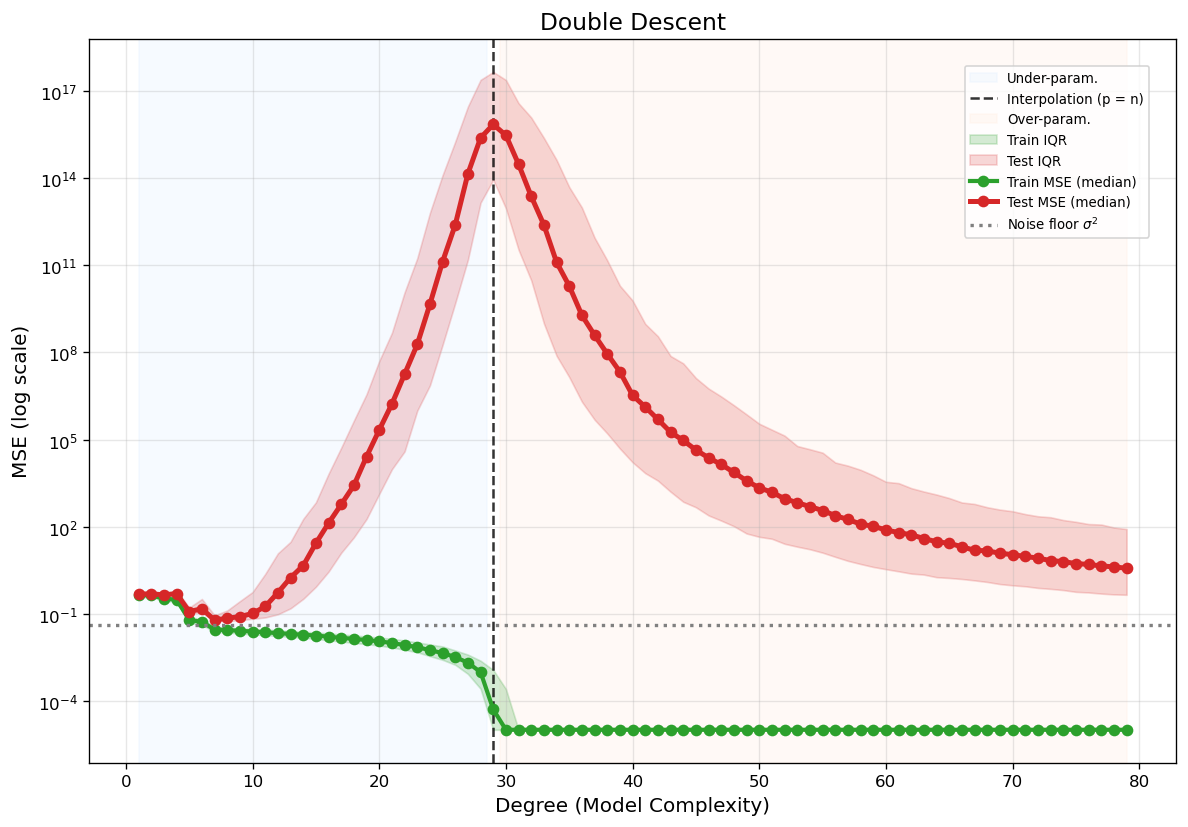

In [7]:
# ==============================================================================
# STANDALONE PRESENTATION PLOT: Robust Median Analysis
# (Run this immediately after your main analysis block)
# ==============================================================================

# 1. Setup a large figure for projection (10x7 is good for 4:3 or 16:9 screens)
fig, ax = plt.subplots(figsize=(10, 7), dpi=120)

# 2. Config from your environment
zoom_limit = max(degrees)
plot_degrees = [d for d in degrees if d <= zoom_limit]
robust_rcond = RCOND 
MSE_FLOOR = 1e-5  # Your fix for the log-scale drop

# 3. Re-generate local test data (using same logic as your block)
#    We preserve the RNG state to keep it consistent
rng_state = torch.random.get_rng_state()
X_test_clean = torch.linspace(DOMAIN_MIN, DOMAIN_MAX, 1000).unsqueeze(-1)
y_test_clean = true_function(X_test_clean)
y_test_noisy = y_test_clean + SIGMA_NOISE * torch.randn_like(y_test_clean)
torch.random.set_rng_state(rng_state)

# 4. Calculation Loop (Re-computing to apply the MSE_FLOOR fix)
train_med, test_med = [], []
train_q25, train_q75 = [], []
test_q25,  test_q75  = [], []

print(f"Generating Presentation Plot (d=1..{zoom_limit})...")

for d in plot_degrees:
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=robust_rcond)

    # --- TRAIN ---
    Phi_tr = make_basis(X_train_K, d, BASIS)
    y_pred_tr = torch.einsum('kd,knd->kn', betas, Phi_tr) 
    mse_k_tr = torch.mean((y_pred_tr - y_train_K)**2, dim=1) 
    
    # [Leon's Fix] Clamp numerical noise
    mse_k_tr = torch.clamp(mse_k_tr, min=MSE_FLOOR)

    train_med.append(torch.median(mse_k_tr).item())
    train_q25.append(torch.quantile(mse_k_tr, 0.25).item())
    train_q75.append(torch.quantile(mse_k_tr, 0.75).item())

    # --- TEST ---
    Phi_te = make_basis(X_test_clean.squeeze(-1), d, BASIS)
    y_pred_te = torch.matmul(betas, Phi_te.T) 
    mse_k_te = torch.mean((y_pred_te - y_test_noisy.squeeze())**2, dim=1) 
    
    # [Leon's Fix] Clamp numerical noise
    mse_k_te = torch.clamp(mse_k_te, min=MSE_FLOOR)

    test_med.append(torch.median(mse_k_te).item())
    test_q25.append(torch.quantile(mse_k_te, 0.25).item()) 
    test_q75.append(torch.quantile(mse_k_te, 0.75).item()) 

# 5. Prepare Arrays using your global helper
deg_z = np.array(plot_degrees)
tr_med = _clean_log(np.array(train_med))
te_med = _clean_log(np.array(test_med))
tr_q25 = _clean_log(np.array(train_q25))
tr_q75 = _clean_log(np.array(train_q75))
te_q25 = _clean_log(np.array(test_q25))
te_q75 = _clean_log(np.array(test_q75))

# 6. Regime Shading
dmin, dmax = int(deg_z.min()), int(deg_z.max())
# Under-parameterized (light blue)
ax.axvspan(dmin, max(dmin, thresh_d - 0.5), color='#e6f2ff', alpha=0.35, label='Under-param.')
# Interpolation line
ax.axvline(thresh_d, color='black', ls='--', lw=1.5, alpha=0.8, label='Interpolation (p = n)')
# Over-parameterized (light orange)
ax.axvspan(thresh_d + 0.5, dmax, color='#fff0e6', alpha=0.35, label='Over-param.')

# 7. IQR Bands & Medians
ax.fill_between(deg_z, tr_q25, tr_q75, color='tab:green', alpha=0.20, label='Train IQR')
ax.fill_between(deg_z, te_q25, te_q75, color='tab:red',   alpha=0.18, label='Test IQR')

# Thicker lines for projector visibility
ax.plot(deg_z, tr_med, 'o-', lw=2.5, markersize=6, color='tab:green', label='Train MSE (median)')
ax.plot(deg_z, te_med, 'o-', lw=3.0, markersize=6, color='tab:red',   label='Test MSE (median)')

# 8. Styling & Legend
ax.axhline(y=sigma2, color='gray', ls=':', lw=2.0, label=r'Noise floor $\sigma^2$')
ax.set_yscale('log')

# Larger fonts for presentation
ax.set_title('Double Descent', fontsize=14)
ax.set_ylabel('MSE (log scale)', fontsize=12)
ax.set_xlabel('Degree (Model Complexity)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(alpha=0.3, which='both')

# De-duplicate legend labels
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))

# [Leon's Request] loc='best' with padding to nudge it down
ax.legend(
    uniq.values(), 
    uniq.keys(), 
    fontsize=8,         # Larger legend text
    loc='best', 
    borderaxespad=2.0    # Pushes the legend inward
)

plt.tight_layout()
plt.show()

Generating Smooth Presentation Plot (d=1..12)...


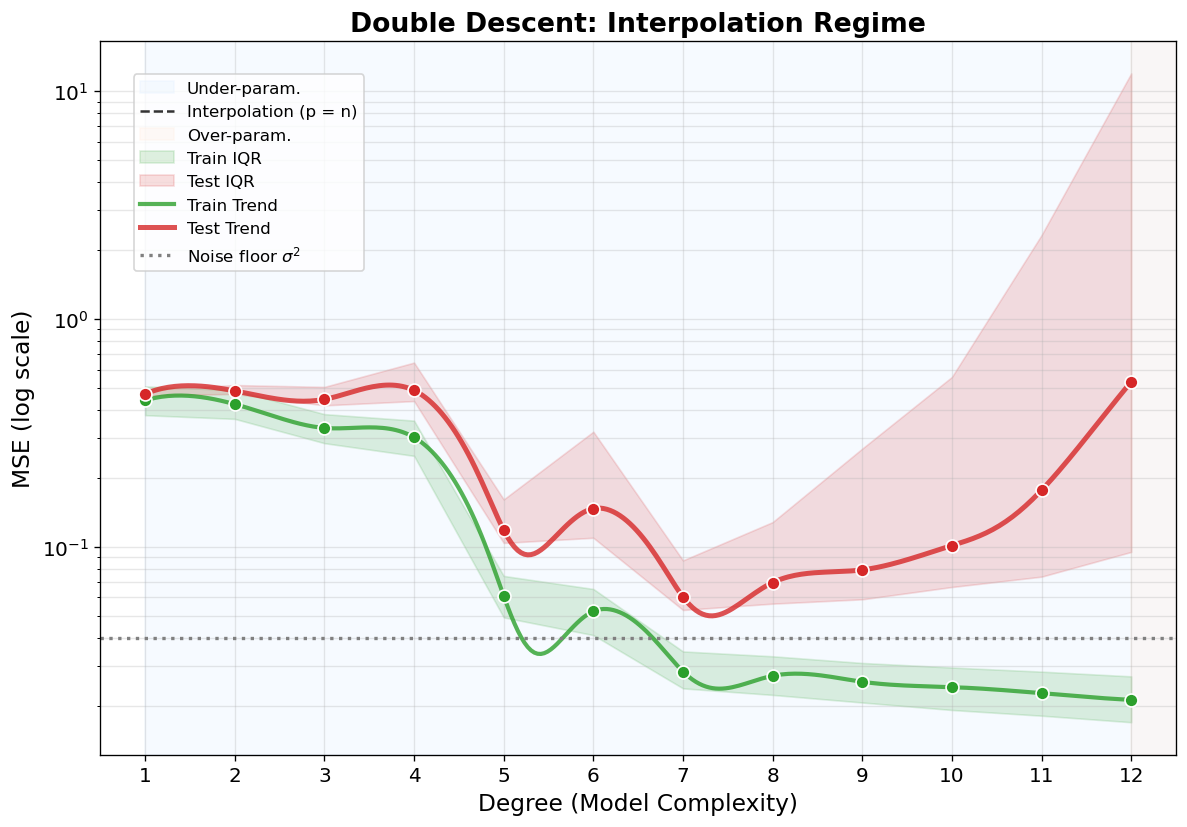

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline # <--- NEW IMPORT

# ==============================================================================
# STANDALONE PRESENTATION PLOT: Smooth U-Curve
# ==============================================================================

# 1. Setup
fig, ax = plt.subplots(figsize=(10, 7), dpi=120)

# 2. Config
zoom_limit = 12
plot_degrees = [d for d in degrees if d <= zoom_limit]
robust_rcond = RCOND 
MSE_FLOOR = 1e-5 

# 3. Data Generation (Standard)
rng_state = torch.random.get_rng_state()
X_test_clean = torch.linspace(DOMAIN_MIN, DOMAIN_MAX, 1000).unsqueeze(-1)
y_test_clean = true_function(X_test_clean)
y_test_noisy = y_test_clean + SIGMA_NOISE * torch.randn_like(y_test_clean)
torch.random.set_rng_state(rng_state)

# 4. Calculation Loop
train_med, test_med = [], []
train_q25, train_q75 = [], []
test_q25,  test_q75  = [], []

print(f"Generating Smooth Presentation Plot (d=1..{zoom_limit})...")

for d in plot_degrees:
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=robust_rcond)

    # TRAIN
    Phi_tr = make_basis(X_train_K, d, BASIS)
    y_pred_tr = torch.einsum('kd,knd->kn', betas, Phi_tr) 
    mse_k_tr = torch.mean((y_pred_tr - y_train_K)**2, dim=1) 
    mse_k_tr = torch.clamp(mse_k_tr, min=MSE_FLOOR) # Clamp

    train_med.append(torch.median(mse_k_tr).item())
    train_q25.append(torch.quantile(mse_k_tr, 0.25).item())
    train_q75.append(torch.quantile(mse_k_tr, 0.75).item())

    # TEST
    Phi_te = make_basis(X_test_clean.squeeze(-1), d, BASIS)
    y_pred_te = torch.matmul(betas, Phi_te.T) 
    mse_k_te = torch.mean((y_pred_te - y_test_noisy.squeeze())**2, dim=1) 
    mse_k_te = torch.clamp(mse_k_te, min=MSE_FLOOR) # Clamp

    test_med.append(torch.median(mse_k_te).item())
    test_q25.append(torch.quantile(mse_k_te, 0.25).item()) 
    test_q75.append(torch.quantile(mse_k_te, 0.75).item()) 

# 5. Prepare Arrays
deg_z = np.array(plot_degrees)
tr_med = _clean_log(np.array(train_med))
te_med = _clean_log(np.array(test_med))
tr_q25 = _clean_log(np.array(train_q25))
tr_q75 = _clean_log(np.array(train_q75))
te_q25 = _clean_log(np.array(test_q25))
te_q75 = _clean_log(np.array(test_q75))

# ==============================================================================
# LEON'S UPGRADE: SMOOTHING LOGIC
# ==============================================================================
def get_smooth_curve(x, y, num_points=300, k=3):
    """
    Interpolates x, y using B-Splines to create a smooth curve.
    k=3 is cubic smoothing.
    """
    # Create a dense X-axis
    x_new = np.linspace(x.min(), x.max(), num_points)
    # Generate the spline
    spl = make_interp_spline(x, y, k=k)
    y_smooth = spl(x_new)
    return x_new, y_smooth

# Generate smooth versions of the MEDIAN lines only
deg_smooth, tr_med_smooth = get_smooth_curve(deg_z, tr_med)
_, te_med_smooth = get_smooth_curve(deg_z, te_med)


# 6. Regime Shading
dmin, dmax = int(deg_z.min()), int(deg_z.max())
ax.axvspan(dmin, max(dmin, thresh_d - 0.5), color='#e6f2ff', alpha=0.35, label='Under-param.')
ax.axvline(thresh_d, color='black', ls='--', lw=1.5, alpha=0.8, label='Interpolation (p = n)')
ax.axvspan(thresh_d + 0.5, dmax, color='#fff0e6', alpha=0.35, label='Over-param.')

# 7. Plotting

# A) The IQR Bands (Keep these blocky or they look fake)
ax.fill_between(deg_z, tr_q25, tr_q75, color='tab:green', alpha=0.15, label='Train IQR')
ax.fill_between(deg_z, te_q25, te_q75, color='tab:red',   alpha=0.15, label='Test IQR')

# B) The SMOOTH Lines (The Trend)
ax.plot(deg_smooth, tr_med_smooth, '-', lw=2.5, color='tab:green', alpha=0.8, label='Train Trend')
ax.plot(deg_smooth, te_med_smooth, '-', lw=3.0, color='tab:red',   alpha=0.8, label='Test Trend')

# C) The REAL Data Points (The Truth) - Plotted as dots on top
ax.scatter(deg_z, tr_med, color='tab:green', s=60, edgecolors='white', zorder=5)
ax.scatter(deg_z, te_med, color='tab:red',   s=60, edgecolors='white', zorder=5)


# 8. Styling & Centering
ax.axhline(y=sigma2, color='gray', ls=':', lw=2.0, label=r'Noise floor $\sigma^2$')
ax.set_yscale('log')

ax.set_title('Double Descent: Interpolation Regime', fontsize=16, weight='bold')
ax.set_ylabel('MSE (log scale)', fontsize=14)
ax.set_xlabel('Degree (Model Complexity)', fontsize=14)

# --- FORCING CENTERING ---
# 1. Set explicit X-ticks for every integer (1, 2, 3...)
ax.set_xticks(plot_degrees)
# 2. Add a tiny padding to left/right so points aren't cut off
ax.set_xlim(min(plot_degrees)-0.5, max(plot_degrees)+0.5)
# -------------------------

ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(alpha=0.3, which='both')

# Legend
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), fontsize=10, loc='best', borderaxespad=2.0)

plt.tight_layout()
plt.show()